In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'iyw' # ticker symbol
model_name = 'Random Forest Classifier' # for display later
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds

In [3]:
# Extract, Transform, Load, and Train Test Split
# aapl start date: 12/12/1980, trained 12/23/20
# tsla start date: 06/29/2010, trained 12/23/20
# vbiv start date: 09/04/2002, trained 12/23/20
# vgt start date: 01/26/2004, trained 12/23/20
# idex start date: 05/23/2007, trained 12/23/20
# iyw start date: 05/15/2000, trained 12/23/20
# 
start_dates = {'aapl':'12/12/1980'
               , 'amd': '03/17/1980'
               , 'baba': '09/15/2014'
               , 'crm': '06/23/2004'
               , 'goog': '08/16/2004'
               , 'idex': '05/23/2007'
               , 'iyw': '05/15/2000'
               , 'nvda': '01/22/1999'
               , 'pypl': '07/05/2015'
               , 'tsla': '06/29/2010'
               , 'vbiv': '09/04/2002'
               , 'vgt': '01/26/2004'
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-11,82.139999,81.169998,81.680000,82.110001,171500.0,82.032005,-0.005264,0.011950,-0.000243,0.011295,-0.001904,1
2020-12-14,82.879997,82.199997,82.309998,82.260002,225400.0,82.260002,0.000607,0.008273,0.002779,0.011194,-0.002077,1
2020-12-15,83.589996,82.690002,83.010002,83.589996,193800.0,83.589996,-0.006987,0.010884,0.016168,0.013870,0.000411,-1
2020-12-16,84.389999,83.400002,83.669998,84.139999,202500.0,84.139999,-0.005617,0.011870,0.006580,0.006200,0.006085,-1
2020-12-17,84.870003,84.290001,84.709999,84.660004,471800.0,84.660004,0.000590,0.006881,0.006180,0.006178,0.006293,-1
2020-12-18,84.849998,83.970001,84.849998,84.480003,403300.0,84.480003,0.004361,0.010480,-0.002126,0.006711,0.005916,1
2020-12-21,84.709999,82.839996,83.540001,84.669998,329200.0,84.669998,-0.013526,0.022574,0.002249,0.006777,0.005810,1
2020-12-22,85.839996,84.660004,85.150002,85.449997,357600.0,85.449997,-0.003523,0.013938,0.009212,0.004424,0.004419,-1
2020-12-23,85.540001,84.779999,85.540001,84.820000,222400.0,84.820000,0.008417,0.008964,-0.007373,0.006590,0.001629,1


In [5]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5179 entries, 2000-05-26 to 2020-12-24
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   High        5179 non-null   float64
 1   Low         5179 non-null   float64
 2   Open        5179 non-null   float64
 3   Close       5179 non-null   float64
 4   Volume      5179 non-null   float64
 5   Adj Close   5179 non-null   float64
 6   oc          5179 non-null   float64
 7   hl          5179 non-null   float64
 8   adj         5179 non-null   float64
 9   5stdev_adj  5179 non-null   float64
 10  5sma_adj    5179 non-null   float64
 11  direction   5179 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 526.0 KB


In [6]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
# a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)

In [7]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

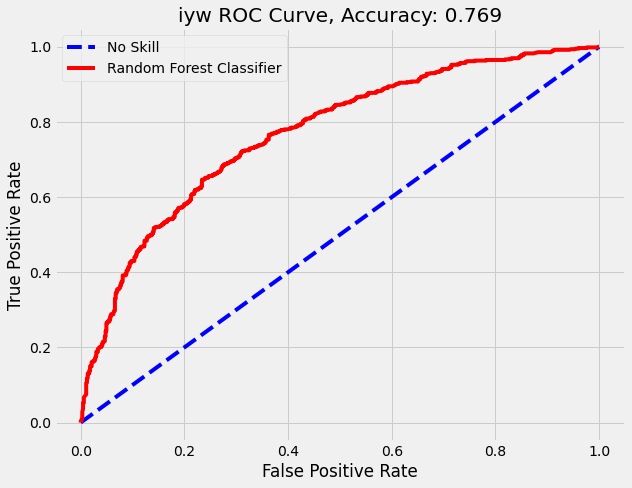

In [8]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

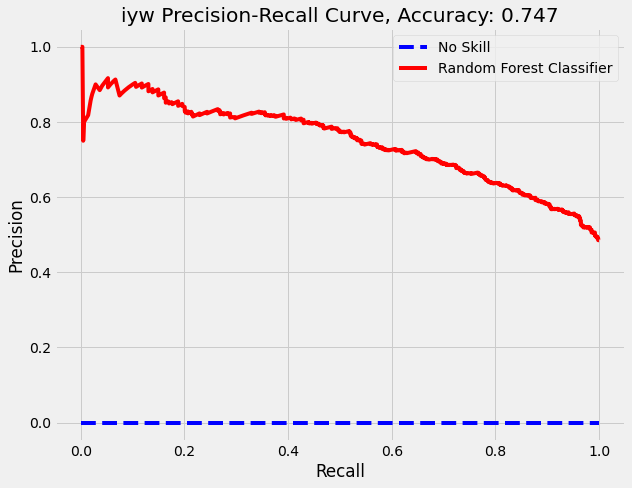

In [9]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

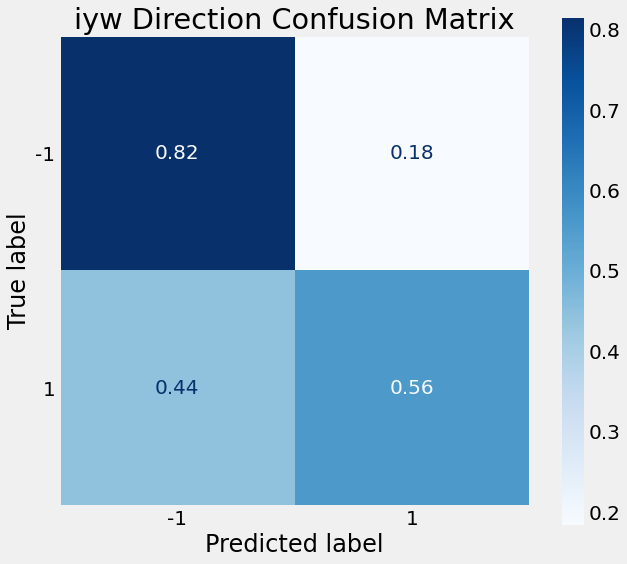

In [10]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [11]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.7097866189170536'

In [12]:
# Prediction, use last day of data
stock_df.iloc[-1]

High              85.430000
Low               84.860001
Open              84.910004
Close             85.180000
Volume        105900.000000
Adj Close         85.180000
oc                -0.003180
hl                 0.006717
adj                0.004244
5stdev_adj         0.006307
5sma_adj           0.001241
direction         -1.000000
Name: 2020-12-24 00:00:00, dtype: float64

In [13]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc           -0.003180
hl            0.006717
5stdev_adj    0.006307
5sma_adj      0.001241
Name: 2020-12-24 00:00:00, dtype: float64

### Prediction...

In [14]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Sell or hold iyw


In [15]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-18,84.849998,83.970001,84.849998,84.480003,403300.0,84.480003,0.004361,0.010480,-0.002126,0.006711,0.005916,1,1,0.002249
2020-12-21,84.709999,82.839996,83.540001,84.669998,329200.0,84.669998,-0.013526,0.022574,0.002249,0.006777,0.005810,1,-1,-0.009212
2020-12-22,85.839996,84.660004,85.150002,85.449997,357600.0,85.449997,-0.003523,0.013938,0.009212,0.004424,0.004419,-1,-1,0.007373
2020-12-23,85.540001,84.779999,85.540001,84.820000,222400.0,84.820000,0.008417,0.008964,-0.007373,0.006590,0.001629,1,1,0.004244
2020-12-24,85.430000,84.860001,84.910004,85.180000,105900.0,85.180000,-0.003180,0.006717,0.004244,0.006307,0.001241,-1,-1,-0.001112


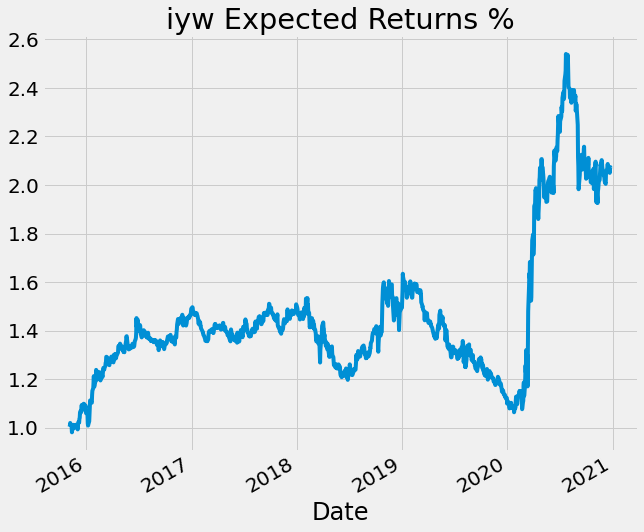

In [17]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

2.794880585533739

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) /stock_df['Close'][-test_idx]

6.033856541705927

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/